In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score

archivos = {
    "GPT-4o-mini": "./datos/Clasificación_GPT-4o-mini-Completo.xlsx",
    "LLaMA-3.1-8b-instant": "./datos/Clasificación_llama-3.1-8b-instant-Completo.xlsx",
    "LLaMa-3.3-70b-versatile": "./datos/Clasificación_llama-3.3-70b-versatile-Completo.xlsx",
    "Gemma2-9b-it": "./datos/Clasificación_gemma2-9b-it-Completo.xlsx",
    "Robertuito": "./datos/Clasificación_Robertuito_2019.xlsx"
}


prompts = {"ZeroShot": "ZS", "FewShot": "FS", "Chain_Of_Thought": "CoT"}
clases_validas = ["NEG", "NEU", "POS"]


dataframes = {nombre: pd.read_excel(path) for nombre, path in archivos.items()}
y_true = dataframes["GPT-4o-mini"]["Polarity"]

In [8]:
def calcular_metricas(y_true, y_pred, clases=["NEG", "NEU", "POS"]):
    report = classification_report(y_true, y_pred, labels=clases, output_dict=True, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)

    # Extraer f1-score por clase
    metricas_clase = {clase: {
        "precision": report[clase]["precision"],
        "recall": report[clase]["recall"],
        "f1-score": report[clase]["f1-score"]
    } for clase in clases}

    return {
        "accuracy": accuracy,
        "f1-score": report["weighted avg"]["f1-score"],
        "metricas_por_clase": metricas_clase
    }

In [9]:
resultados = []

for modelo, df in dataframes.items():
    if modelo == "Robertuito":
        pred = df["Polarity_Robertuito"]
        resultados.append({"Modelo": modelo, "Prompt": "-", **calcular_metricas(y_true, pred, clases_validas)})
    else:
        for col in df.columns:
            if "Polarity_" in col:
                prompt_key = next((p for p in prompts if p in col), None)
                if prompt_key:
                    pred = df[col]
                    resultados.append({
                        "Modelo": modelo,
                        "Prompt": prompts[prompt_key],
                        **calcular_metricas(y_true, pred, clases_validas)
                    })

df_resultados = pd.DataFrame(resultados)


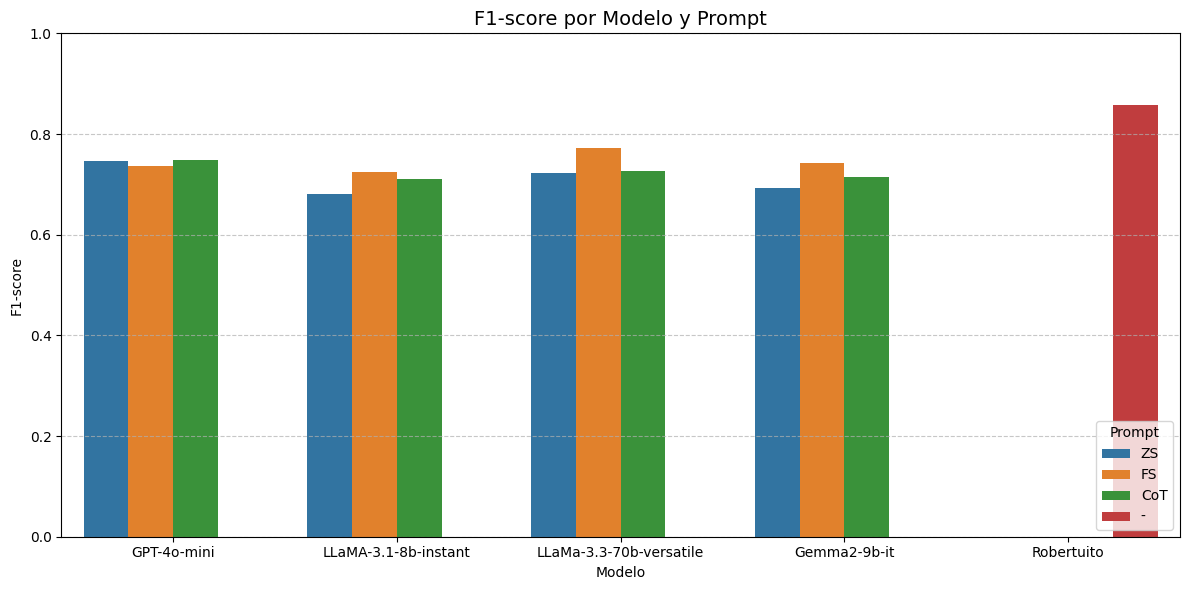

In [10]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_resultados, x="Modelo", y="f1-score", hue="Prompt")
plt.title("F1-score por Modelo y Prompt", fontsize=14)
plt.ylabel("F1-score")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Prompt", loc="lower right")
plt.tight_layout()
plt.show()

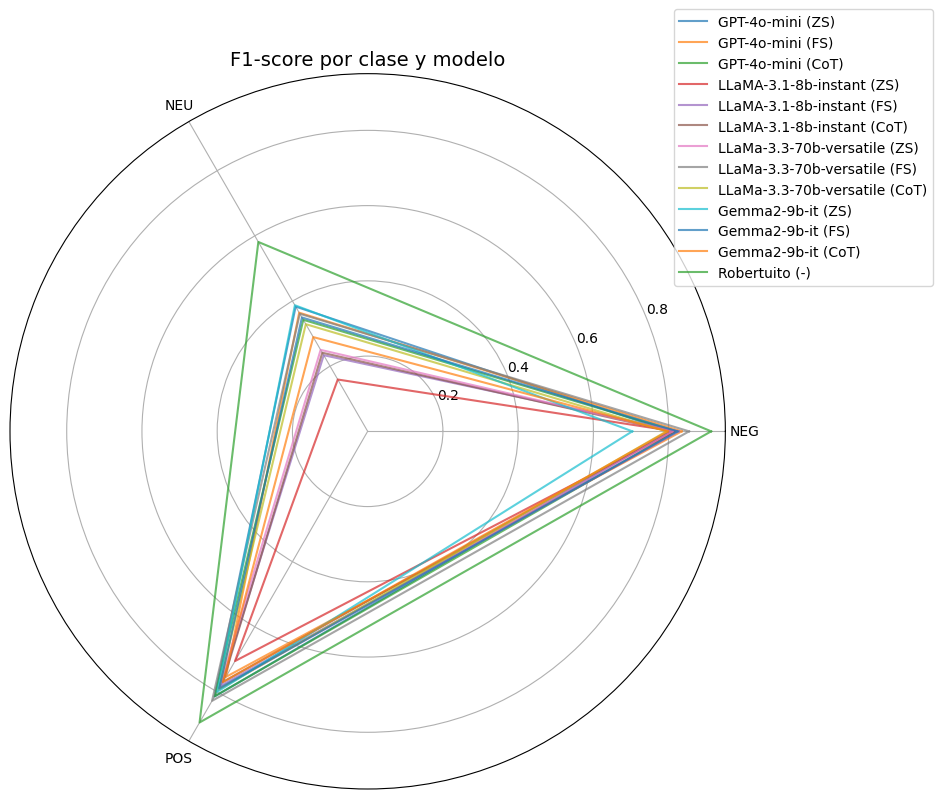

In [ ]:
# Radar
labels = list(clases_validas)
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(10, 8))
for _, row in df_radar.iterrows():
    valores = [row[c] for c in labels] + [row[labels[0]]]
    plt.polar(angles, valores, label=f"{row['Modelo']} ({row['Prompt']})", alpha=0.7)

plt.xticks(angles[:-1], labels)
plt.title("F1-score por clase y modelo", fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

In [5]:
for modelo, df in dataframes.items():
    if modelo == "NLP":
        continue
    for raw_col in df.columns:
        if "Polarity_" in raw_col and any(k in raw_col for k in prompts):
            prompt = next(p for k, p in prompts.items() if k in raw_col)
            y_pred = df[raw_col]

            # Validación
            valid_mask = y_pred.isin(clases_validas) & polaridad_true.isin(clases_validas)
            y_true_filtrado = polaridad_true[valid_mask]
            y_pred_filtrado = y_pred[valid_mask]

            # Métricas si hay datos
            if len(y_pred_filtrado) > 0:
                metrica = calcular_metricas(
                    y_true_filtrado, y_pred_filtrado, clases_validas)
                resultados_limpios.append({
                    "Modelo": modelo,
                    "Prompt": prompt,
                    **metrica
                })

df_metricas_limpias = pd.DataFrame(resultados_limpios)


In [6]:
print(df_metricas_limpias)
df_metricas_limpias.to_excel("comparativa_llm_vs_nlp.xlsx", index=False)


                     Modelo Prompt  precision    recall  f1-score  \
0                Robertuito      -   0.868402  0.851240  0.857975   
1               GPT-4o-mini     ZS   0.769906  0.731405  0.746709   
2               GPT-4o-mini     FS   0.755480  0.726240  0.737184   
3               GPT-4o-mini    CoT   0.755730  0.743802  0.748330   
4      LLaMA-3.1-8b-instant     ZS   0.690825  0.700413  0.680676   
5      LLaMA-3.1-8b-instant     FS   0.715669  0.744835  0.724330   
6      LLaMA-3.1-8b-instant    CoT   0.714624  0.732438  0.710917   
7   LLaMa-3.3-70b-versatile     ZS   0.716813  0.731405  0.722540   
8   LLaMa-3.3-70b-versatile     FS   0.770123  0.778926  0.773097   
9   LLaMa-3.3-70b-versatile    CoT   0.745562  0.722107  0.726495   
10             Gemma2-9b-it     ZS   0.798264  0.657025  0.692753   
11             Gemma2-9b-it     FS   0.754116  0.734504  0.742049   
12             Gemma2-9b-it    CoT   0.725361  0.722107  0.713822   

                                 

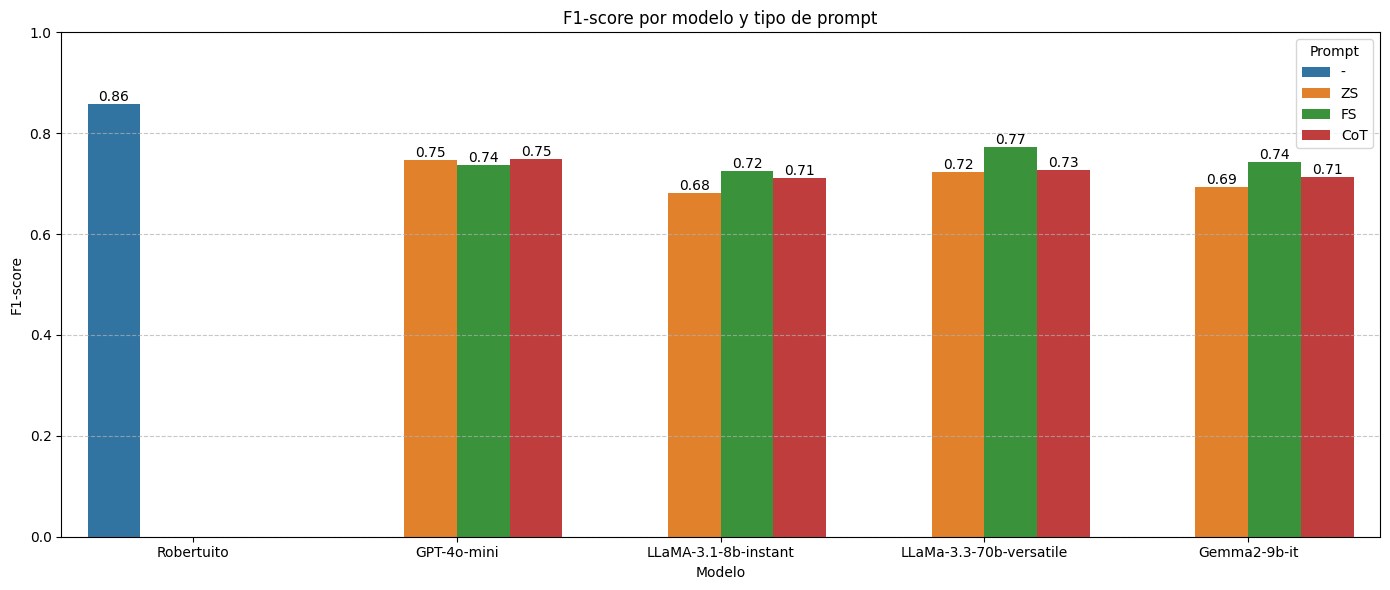

In [7]:
plt.figure(figsize=(14, 6))
sns.barplot(data=df_metricas_limpias, x="Modelo", y="f1-score", hue="Prompt")
plt.title("F1-score por modelo y tipo de prompt")
plt.ylim(0, 1)
plt.ylabel("F1-score")
plt.legend(title="Prompt")
plt.grid(axis='y', linestyle='--', alpha=0.7)
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.2f', label_type='edge', fontsize=10)
plt.tight_layout()
plt.show()